# Prior distributions and their impacts

Every parameter has a distribution that represents our believes. In particular, before any new evidence brought by the likelihood of the model, we have to consider a distribution before observing the data, the prior distribution. However, it is not easy to transform prior information about a parameter into a prior distribution and bad things can happen if we do not think carefully about it. 

In [1]:
import numpy as np
import pystan as ps

from scipy.stats import loggamma

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
sns.set()
%matplotlib inline

from tqdm.notebook import tqdm

import sys
sys.path.append('../scripts/')

from utilits import ParameterAlpha

## Defining prior distributions on $\alpha$

As we estabished, we want to define a jointly distribution for the Sensitivity and Specificity thorough the Bivariate Beta distribution defined [before](bivariate-beta). Then we can fix the parameter $\alpha = (\alpha_1, \dots, \alpha_4)$ or we can define a prior distribution over it. We will compare then afterwards. 

### The parameter is fixed

Suppose we have prior information about sensitivity and specificity. In general, the mean of each of them are a well known statistic. Other commom information is the stardard deviation or some credible interval. The ideia is to find the $\alpha$ parameter that generate the desired statistics. As proved [previously](choosing-alpha), we can calculate the error over specificity's variance if we fix the others, including the correlation parameter or not. There are two options we can follow, such as, minimizing a loss function or solving four equations and letting the sencond variance as a consequence. In the end, the result will be a $\hat{\alpha}$. This approximation will be the parameter of Bivariate Beta distribution. 

### The parameter has a distribution

We will start with the Gamma distribution, that is, 

$$
\alpha_i \sim Gamma(a^i, b^i), 
$$

such that $\mathbb{E}[\alpha_i] = a^i/b^i = \hat{\alpha}_i$ as explained before. The variance $\operatorname{Var}(\alpha_i) = a_i/b_i^2 = \hat{\alpha}_i/b_i$ will be compared numerically for different values of $b_i$. 

In [4]:
def moments_calculus(alpha): 
    
    tilde_alpha = alpha[0]+alpha[1]+alpha[2]+alpha[3]
    
    E_X = (alpha[0]+alpha[1])/tilde_alpha
    E_Y = (alpha[0]+alpha[2])/tilde_alpha
    
    Var_X = (1/(tilde_alpha*(tilde_alpha+1)))*E_X*(alpha[2] + alpha[3])
    Var_Y = (1/(tilde_alpha*(tilde_alpha+1)))*E_Y*(alpha[1] + alpha[3])
    
    den = np.log(alpha[0] + alpha[1]) + np.log(alpha[2]+alpha[3]) + np.log(alpha[0]+alpha[2]) + np.log(alpha[1]+alpha[3])
    den = np.exp(-0.5*den)
    Cor_XY = (alpha[0]*alpha[3] - alpha[1]*alpha[2])*den
    
    return (E_X, E_Y, Var_X, Var_Y, Cor_XY)

As an example, consider the following chosen values. 

$$
m_1 = 0.9, m_2 = 0.85, sd_1 = 0.1, sd_2 = 0.1, \rho = -0.3,
$$

where $m_i$ and $sd_i$ are the mean and standard deviation of sensitivity ($i=1$) and specificity $(i=2)$. The correlation between them is $\rho$. 

In [6]:
m1 = 0.9
m2 = 0.85
v1 = (0.1)**2
v2 = (0.1)**2
rho = -0.3

solution = ParameterAlpha().minimizer(m1,m2,v1,v2,rho)
print(solution.fun)

0.012752358811841972


The values were not so close as we wished, but we can move on from that. 

In [7]:
moments_calculus(solution.x)

(0.8369500912685716,
 0.7969037746346564,
 0.009082567510028991,
 0.010771997634362348,
 -0.22282214689412486)

And the solution:

In [22]:
print('alpha_hat: {}'.format(solution.x))

alpha_hat: [8.88973495e+00 2.84840338e+00 2.28675794e+00 1.38106482e-07]


The following function is used to obtain the Gamma parameters. We will have that 

$$
\mathbb{E}[\alpha_i] = \hat{\alpha_i} = \frac{a_i}{b_i} \implies a_i = b_i\alpha_i
$$

Therefore, 

$$
\operatorname{Var}(\alpha_i) = \frac{a_i}{b_i^2} = \frac{\hat{\alpha_i}}{b_i} \implies b_i = \frac{\hat{\alpha_i}}{Var(\alpha_i)}
$$So

So, we will specify $\hat{\alpha}_i$ and $Var(\alpha_i)$ to obtain the parameters. Other interesting parameter is the Coefficient of variation $1/\sqrt{a_i}$. 

In [23]:
def gamma_parameters(alpha_i_mean, alpha_i_var = None, alpha_i_coef_var = None):
    
    if alpha_i_var is None:
        ai = (1/alpha_i_coef_var)**2
        bi = ai/alpha_i_mean
    else: 
        bi = alpha_i_mean/alpha_i_var
        ai = alpha_i_mean*bi
    return (ai, bi)

With that function, we will analise the following model structure: 

\begin{align}
    \alpha_i &\sim Gamma(a_i, b_i), i = 1, \dots, 4 \\
    U &\sim Dirichilet(\alpha_1, \alpha_2, \alpha_3, \alpha_4) \\
    \gamma_s &= U_1 + U_2 \\
    \gamma_e &= U_1 + U_3 \\
    p &= \gamma_s\theta + (1 - \gamma_e)(1 - \theta), 
\end{align}

such that $\theta$ is fixed, for a while. 

*Remark: In the more complex models, the parameter $p$ (with index $i$)  has more effects on the prior distribution and we will consider it posteriorly.*

In [ ]:
def prior_distributions(a, b, samples = 5000): 
    
    Z = [loggamma(c = a[i]).rvs(size = samples) for i in range(4)]
    alpha = [np.exp(Z[i])/b[i] for i in range(4)]
    
    X = np.random.beta(alpha[0] + alpha[1], alpha[2] + alpha[3])
    Y = np.random.beta(alpha[0] + alpha[2], alpha[1] + alpha[3])
    
    E_X, E_Y, Var_X, Var_Y, Cor_XY = moments_calculus(alpha)
    
    return (X, Y, E_X, E_Y, Var_X, Var_Y, Cor_XY)

### Induced priors

In this model, we specify the priors on $\alpha$. However, the induced priors on the momments of $(X,Y)$ are complicated functions. For this, we generate samples from it. 

#### Vague prior

We first use a vague prior $a_1 = a_2 = a_3 = a_4 = 1/100$ and $b_1 = b_2 = b_3 = b_4 = 1/100$. 

In [72]:
a = np.ones(4)*10
b = np.ones(4)*10

X, Y, E_X, E_Y, Var_X, Var_Y, Cor_XY = prior_distributions(a, b, samples = 10000)

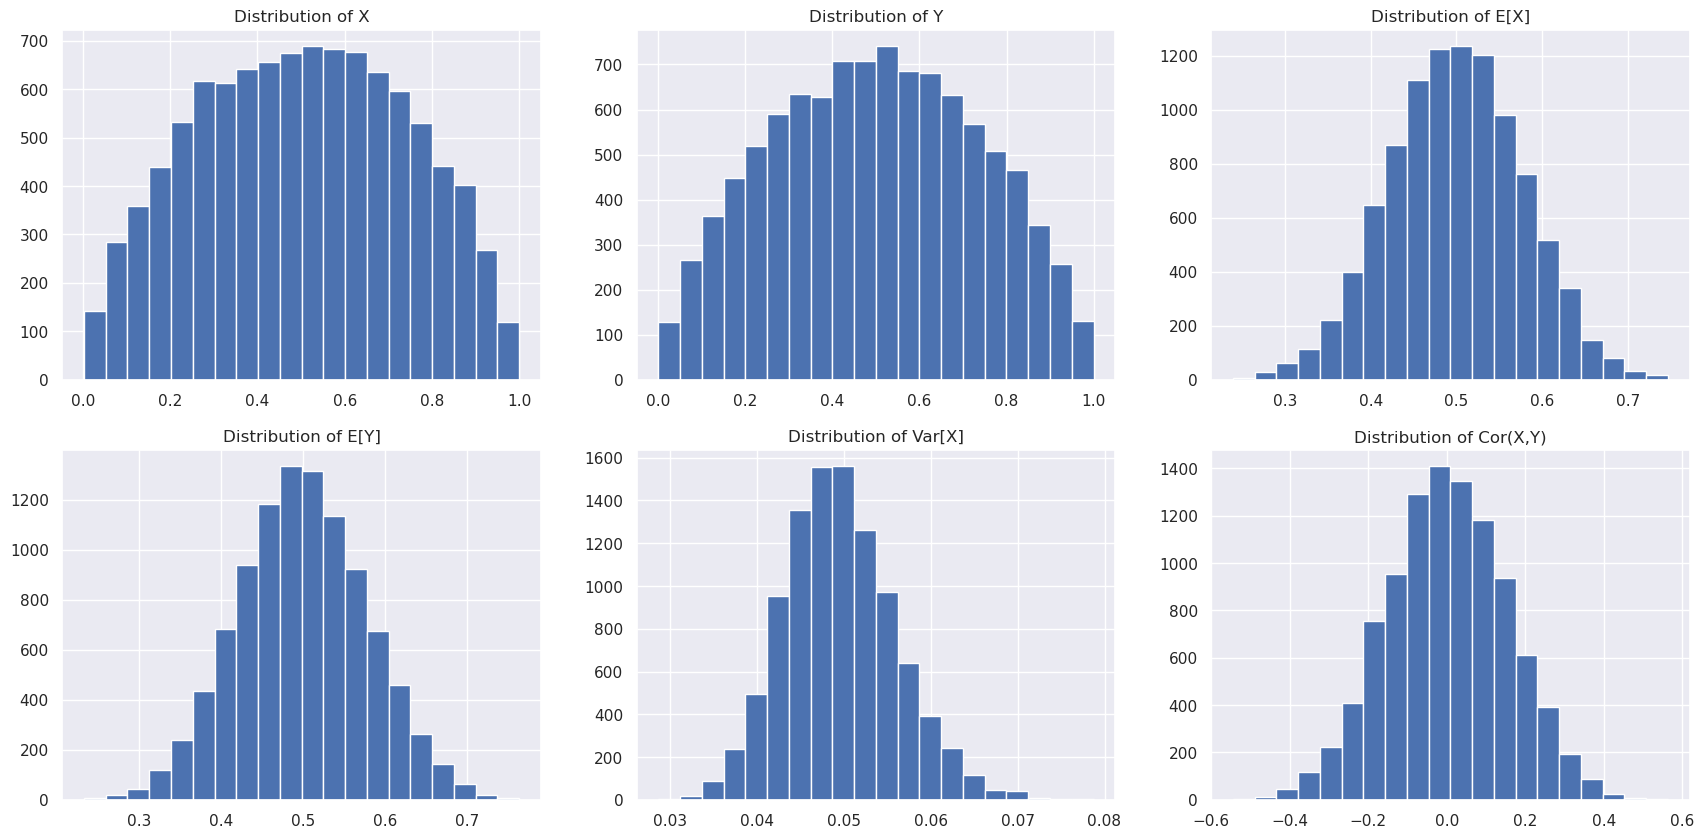

In [73]:
fig, ax = plt.subplots(2,3, figsize = (21,10))

ax[0,0].hist(X, bins = 20)
ax[0,1].hist(Y, bins = 20)
ax[0,2].hist(E_X, bins = 20)
ax[1,0].hist(E_Y, bins = 20)
ax[1,1].hist(Var_X, bins = 20)
ax[1,2].hist(Cor_XY, bins = 20)

ax[0,0].set_title('Distribution of X')
ax[0,1].set_title('Distribution of Y')
ax[0,2].set_title('Distribution of E[X]')
ax[1,0].set_title('Distribution of E[Y]')
ax[1,1].set_title('Distribution of Var[X]')
ax[1,2].set_title('Distribution of Cor(X,Y)')

plt.show()

More informative prior:$a_1 = a_2 = a_3 = a_4 = 1$ and $b_1 = b_2 = b_3 = b_4 = 1$.

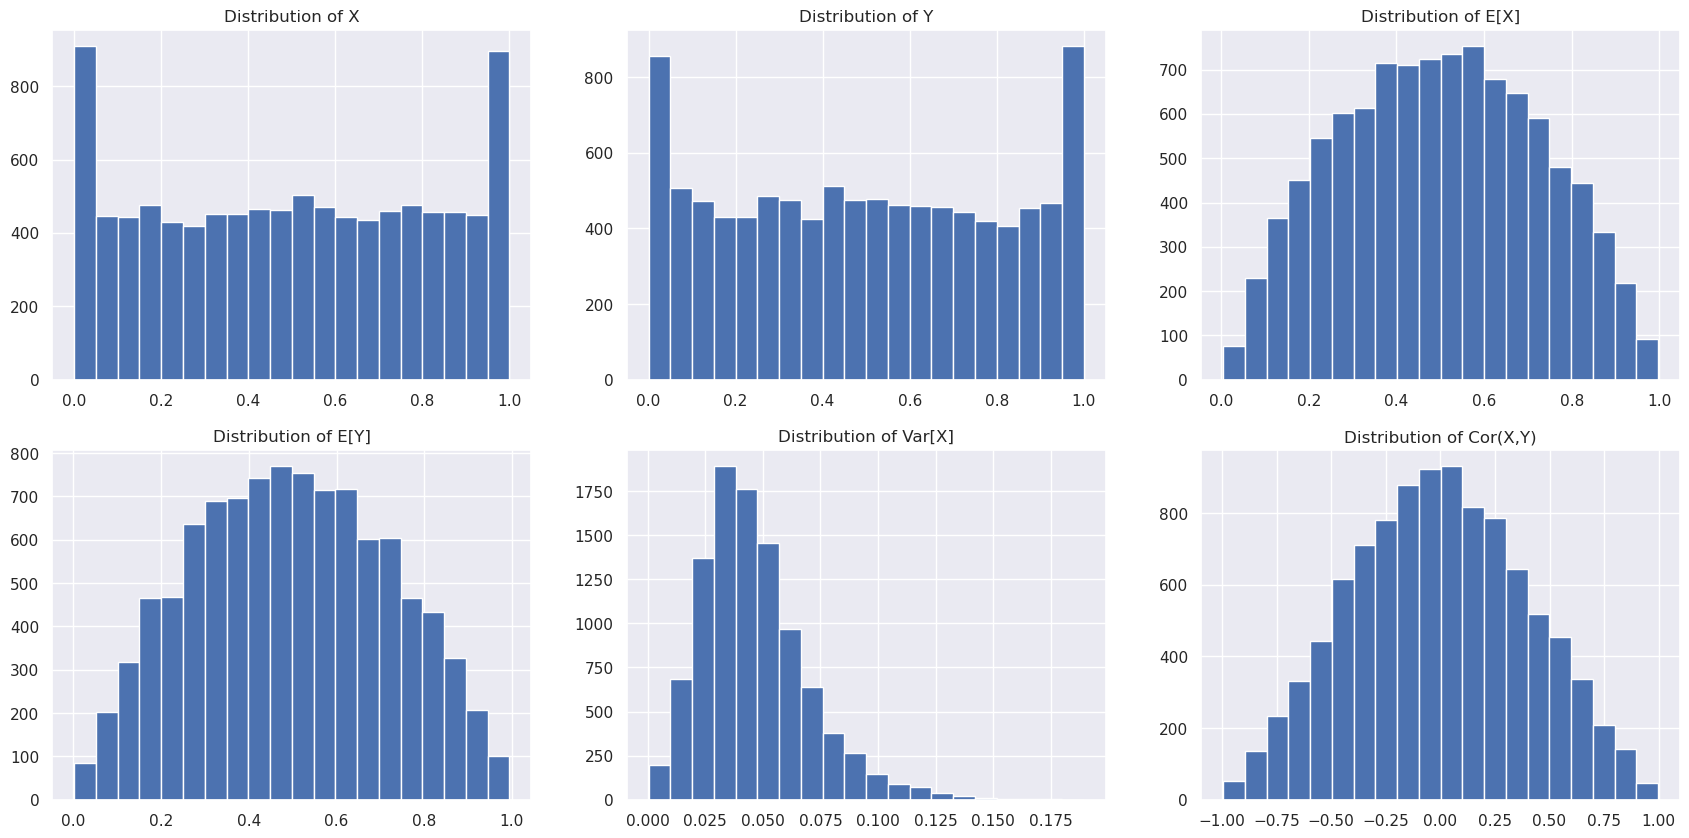

In [9]:
a = np.repeat(1, 4)
b = np.repeat(1, 4)

X, Y, E_X, E_Y, Var_X, Var_Y, Cor_XY = prior_distributions(a, b, samples = 10000)

fig, ax = plt.subplots(2,3, figsize = (21,10))

ax[0,0].hist(X, bins = 20)
ax[0,1].hist(Y, bins = 20)
ax[0,2].hist(E_X, bins = 20)
ax[1,0].hist(E_Y, bins = 20)
ax[1,1].hist(Var_X, bins = 20)
ax[1,2].hist(Cor_XY, bins = 20)

ax[0,0].set_title('Distribution of X')
ax[0,1].set_title('Distribution of Y')
ax[0,2].set_title('Distribution of E[X]')
ax[1,0].set_title('Distribution of E[Y]')
ax[1,1].set_title('Distribution of Var[X]')
ax[1,2].set_title('Distribution of Cor(X,Y)')

plt.show()

After compiling the model, we generate fake data to understand what happens. We will compare independent generated sensitivity and specificity from dependent. For the priors on $\alpha$, weak informative gamma distributions are placed. First, let's see the induced prior on the momments. 

TODO

In [21]:
def gamma_parameters(alpha_i_mean, alpha_i_var): 
    
    bi = alpha_i_mean/alpha_i_var
    ai = alpha_i_mean*bi
    return (ai, bi)

With that function, we will analise the following model structure: 

\begin{align}
    \alpha_i &\sim Gamma(a_i, b_i), i = 1, \dots, 4 \\
    U &\sim Dirichilet(\alpha_1, \alpha_2, \alpha_3, \alpha_4) \\
    \gamma_s &= U_1 + U_2 \\
    \gamma_e &= U_1 + U_3 \\
    p &= \gamma_s\theta + (1 - \gamma_e)(1 - \theta), 
\end{align}

such that $\theta$ is fixed, for a while. 

### $\alpha$ not varying 

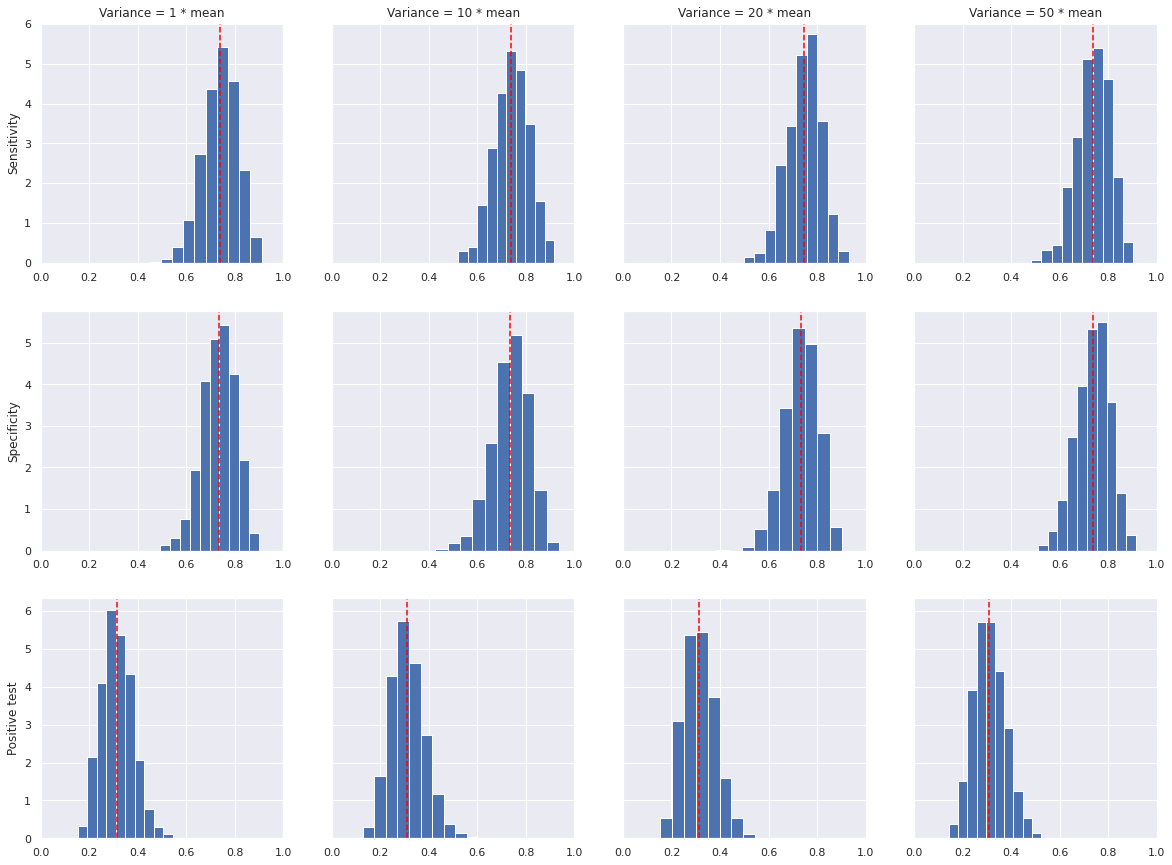

In [32]:
n = 1000
possible_variances = [1, 10, 20, 50]
alpha_hat = solution.x

theta = 0.1

fig, ax = plt.subplots(nrows = 3, ncols = 4, figsize = (20,15), sharey = 'row')

for i, var in enumerate(possible_variances): 
    
    alpha = np.ones((n,4))*alpha_hat
    
    U = np.array([np.random.dirichlet(alpha[s,:]) for s in range(n)])
    gamma_s = U[:,0] + U[:,1]
    gamma_e = U[:,0] + U[:,2]
    p = gamma_s*theta + (1 - gamma_e)*(1 - theta)

    ax[0,i].hist(gamma_s, density = True)
    ax[1,i].hist(gamma_e, density = True)
    ax[2,i].hist(p, density = True)
    
    ax[0,i].axvline(gamma_s.mean(), color = 'red', linestyle = '--')
    ax[1,i].axvline(gamma_e.mean(), color = 'red', linestyle = '--')
    ax[2,i].axvline(p.mean(), color = 'red', linestyle = '--')
    
    ax[0,i].set_xlim((0,1))
    ax[1,i].set_xlim((0,1))
    ax[2,i].set_xlim((0,1))
    
    ax[0,i].set_title('Variance = {} * mean'.format(var))
    
ax[0,0].set_ylabel('Sensitivity')
ax[1,0].set_ylabel('Specificity')
ax[2,0].set_ylabel('Positive test')


plt.show()

### $\alpha$ varying

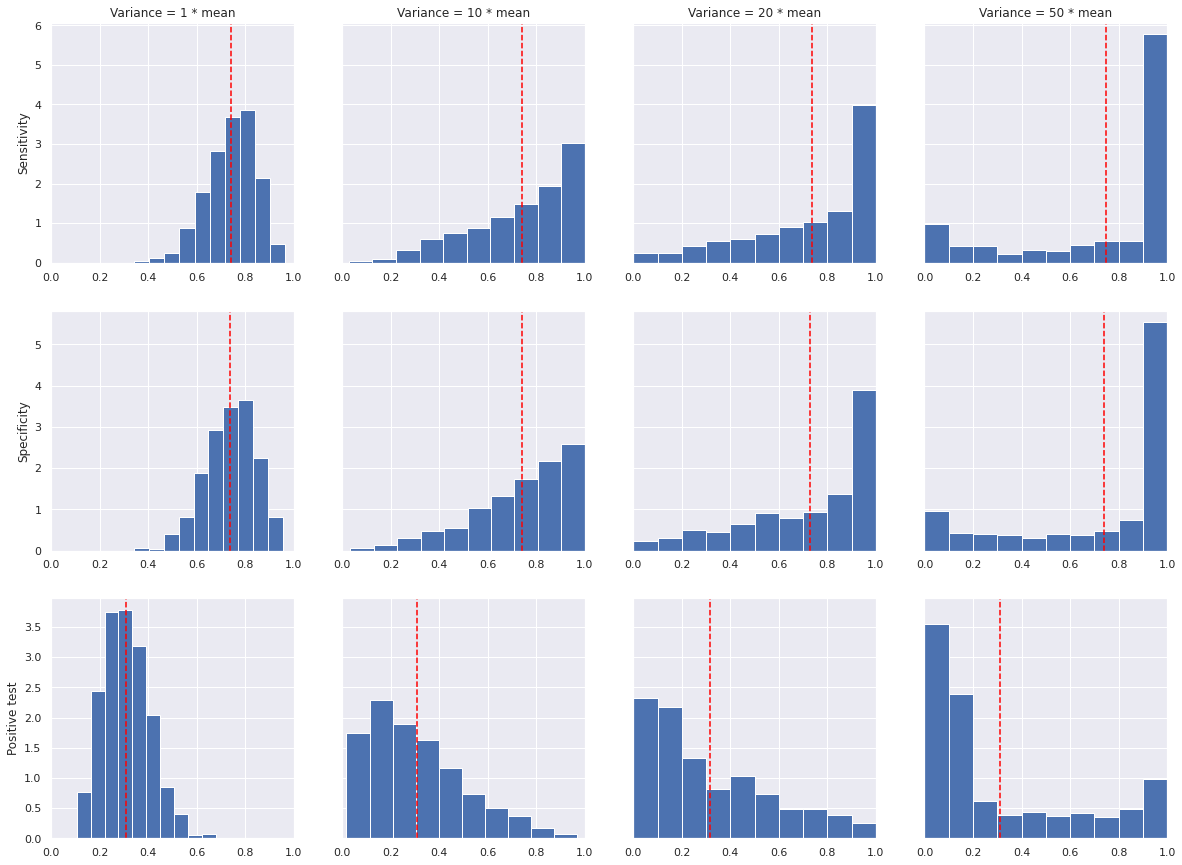

In [22]:
n = 1000
possible_variances = [1, 10, 20, 50]
alpha_hat = solution.x

theta = 0.1

fig, ax = plt.subplots(nrows = 3, ncols = 4, figsize = (20,15), sharey = 'row')

for i, var in enumerate(possible_variances): 
    
    alpha = np.zeros((n,4))
    for j, mean in enumerate(alpha_hat):
        a_j, b_j = gamma_parameters(mean, mean*var)
        alpha[:,j] = np.random.gamma(shape = a_j, scale = 1/b_j, size = n)
    
    U = np.array([np.random.dirichlet(alpha[s,:]) for s in range(n)])
    gamma_s = U[:,0] + U[:,1]
    gamma_e = U[:,0] + U[:,2]
    p = gamma_s*theta + (1 - gamma_e)*(1 - theta)

    ax[0,i].hist(gamma_s, density = True)
    ax[1,i].hist(gamma_e, density = True)
    ax[2,i].hist(p, density = True)
    
    ax[0,i].axvline(gamma_s.mean(), color = 'red', linestyle = '--')
    ax[1,i].axvline(gamma_e.mean(), color = 'red', linestyle = '--')
    ax[2,i].axvline(p.mean(), color = 'red', linestyle = '--')
    
    ax[0,i].set_xlim((0,1))
    ax[1,i].set_xlim((0,1))
    ax[2,i].set_xlim((0,1))
    
    ax[0,i].set_title('Variance = {} * mean'.format(var))
    
ax[0,0].set_ylabel('Sensitivity')
ax[1,0].set_ylabel('Specificity')
ax[2,0].set_ylabel('Positive test')


plt.show()